#### MWPM benchmarks for the toric code with repetitions

Here we will run MWPM for two different strategies
1. Initialize MWPM with a detector error model (weighted detector error graph) corresponding to $\beta p$, and evaluate on errors sampled from $p$
2. Initialize MWPM with a detector error model (weighted detector error graph) corresponding to $p$, and evaluate on errors sampled from $\beta p$

For us, 1. is more relevant but I'm just curious to see whether 2. gives similar behavior in $\beta$.

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2


In [2]:
from mldec.datasets.reps_toric_code_data import make_sampler
from mldec.datasets import reps_toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation
import torch
device = torch.device("cpu")


In [ ]:
from multiprocessing import Pool

# Baseline accuracies: set up pymatching decoder for validation set; do this directly on stim detection events
base_config = {
    "repetitions": 5,
    "code_size": 3,
    "p": 0.001,
    "beta": 1.0,
}
# create a small validation dataset
n_test = int(1e3)


def func(beta_seed, base_config=base_config, n_test=n_test):
    """Initialize MWPM with beta*p, evaluate on errors sampled from p."""
    beta, seed = beta_seed
    data_val, triv_val, stim_data_val, observable_flips_val = reps_toric_code_data.sample_dataset(n_test, base_config, device)
    training_config = base_config.copy()
    training_config["beta"] = beta
    print(training_config)
    _, _, detector_error_model = reps_toric_code_data.make_sampler(training_config)
    mwpm_decoder = baselines.CyclesMinimumWeightPerfectMatching(detector_error_model)
    minimum_weight_correct_nontrivial = evaluation.evaluate_mwpm(stim_data_val, observable_flips_val, mwpm_decoder).item()
    minimum_weight_val_acc = (minimum_weight_correct_nontrivial + triv_val) / n_test
    return minimum_weight_val_acc

def process_beta(beta_seed):
    return func(beta_seed, base_config=base_config, n_test=n_test)

# generate a list of (beta, seed) for beta in range(1, 15) and seed in range(10)
beta_list = range(1, 3)
ntrials = 1
beta_seed_list = [(beta, 1234+ seed) for beta in beta_list for seed in range(ntrials)]

with Pool() as pool:
    errors_per_beta = pool.map(process_beta, beta_seed_list)



In [ ]:
# 'train' a MWPM with the DEM for beta*p
data_val, triv_val, stim_data_val, observable_flips_val = reps_toric_code_data.sample_dataset(n_test, base_config, device)

training_config = base_config.copy()
training_config["beta"] = beta
print(training_config)
_, _, detector_error_model = reps_toric_code_data.make_sampler(training_config)
mwpm_decoder = baselines.CyclesMinimumWeightPerfectMatching(detector_error_model)
minimum_weight_correct_nontrivial = evaluation.evaluate_mwpm(stim_data_val, observable_flips_val, mwpm_decoder).item()
minimum_weight_val_acc = (minimum_weight_correct_nontrivial + triv_val) / n_test
print("minweight acc: {}".format(minimum_weight_val_acc))
errors_per_beta.append(minimum_weight_val_acc)

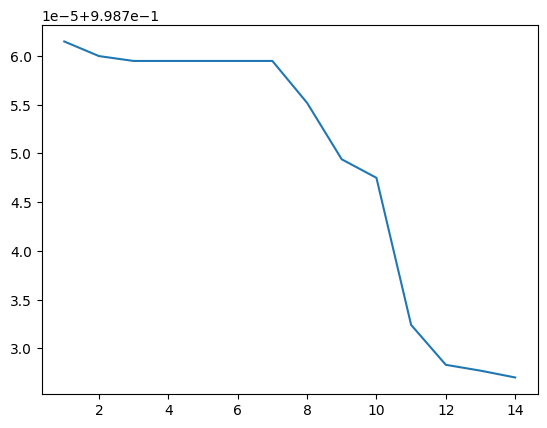

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, 15), errors_per_beta)


In [3]:
import stim, numpy as np
dataset_config = {
    "repetitions": 5,
    "code_size": 3,
    "p": 0.001,
    "beta": 1.0,
}
repetitions = dataset_config.get("repetitions") # "cycles" of measurement
code_size = dataset_config.get("code_size")
p_base = dataset_config.get("p")
beta = dataset_config.get("beta")
p = p_base * beta
# Initialize stim circuit for a fixed training rate
circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds = repetitions,
            distance = code_size,
            after_clifford_depolarization = p,
            after_reset_flip_probability = 0,
            before_measure_flip_probability = 0,
            before_round_data_depolarization = 0)
# get detector coordinates (same for all error rates):
detector_coordinates = circuit.get_detector_coordinates()
detector_coordinates = np.array(list(detector_coordinates.values()))
# rescale space like coordinates:
detector_coordinates[:, : 2] = detector_coordinates[:, : 2] / 2
detector_coordinates = detector_coordinates.astype(np.uint8)
sampler = circuit.compile_detector_sampler() # CompiledDetectorSampler
detector_error_model = circuit.detector_error_model(decompose_errors=True) # DetectorErrorModel
# the detector error model converts the underlying error behavior
# into an error behavior acting on the detectors

In [18]:
import numpy as np
import stim
import pymatching
circuit = stim.Circuit.generated("surface_code:rotated_memory_x", 
                                 distance=5, 
                                 rounds=5, 
                                 after_clifford_depolarization=0.005)

In [2]:
import stim

dem = stim.DetectorErrorModel('''
    error(0.5) D0
    error(1) D1 D2 L0
''')
sampler = dem.compile_sampler()
det_data, obs_data, err_data = sampler.sample(
    shots=4,
    return_errors=True)
print("det_data:")
print(det_data)
print("\nobs_data:")
print(obs_data)
print("\nerr_data:")
print(err_data)

det_data:
[[False  True  True]
 [ True  True  True]
 [False  True  True]
 [ True  True  True]]

obs_data:
[[ True]
 [ True]
 [ True]
 [ True]]

err_data:
[[False  True]
 [ True  True]
 [False  True]
 [ True  True]]
